In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder

# === Load and prepare ===
df = pd.read_csv("Cleaned_Financial_Records.csv")
df["default"] = df["default"].map({1: 0, 2: 1})  # 0 = good, 1 = bad

# === Handle savings and checking_account intelligently ===

# Binary flags for "unknown" or "no checking"
df['savings_unknown'] = df['savings'].str.lower().eq('unknown').astype(int)
df['checking_account_none'] = df['checking_account'].str.lower().str.contains('no checking').astype(int)

# Convert remaining values to numeric (non-convertible values become NaN)
df['savings_numeric'] = pd.to_numeric(df['savings'], errors='coerce')
df['checking_account_numeric'] = pd.to_numeric(df['checking_account'], errors='coerce')

# Fill missing values separately for each class (default = 0 or 1)
df['savings_numeric'] = df.groupby('default')['savings_numeric'].transform(lambda x: x.fillna(x.median()))
df['checking_account_numeric'] = df.groupby('default')['checking_account_numeric'].transform(lambda x: x.fillna(x.median()))

# Drop original columns
df.drop(columns=['savings', 'checking_account'], inplace=True)

# === Continue with bucketing ===

def bucket_employment_since(val):
    val = str(val).strip().lower()
    if val == 'unemployed':
        return 'unemployed'
    if val == '<1 year' or val in ['1', '2', '3', '4']:
        return 'short'
    elif val in ['5', '6', '7']:
        return 'medium'
    else:
        return 'long'

df['employment_since_bucket'] = df['employment_since'].apply(bucket_employment_since)
df.drop(columns=['employment_since'], inplace=True)

def bucket_monthly_rent(val):
    if val == 0:
        return 'none'
    elif val <= 200:
        return 'low'
    elif val <= 400:
        return 'medium'
    else:
        return 'high'

def bucket_credit_amount(val):
    if val <= 1000:
        return 'very_low'
    elif val <= 3000:
        return 'low'
    elif val <= 6000:
        return 'medium'
    else:
        return 'high'

def bucket_duration(val):
    if val <= 12:
        return 'short'
    elif val <= 24:
        return 'medium'
    elif val <= 48:
        return 'long'
    else:
        return 'very_long'

def bucket_age(val):
    if val <= 25:
        return 'young'
    elif val <= 40:
        return 'adult'
    elif val <= 60:
        return 'mature'
    else:
        return 'senior'

df['monthly_rent_bucket'] = df['monthly_rent_or_mortgage'].apply(bucket_monthly_rent)
df['credit_amount_bucket'] = df['credit_amount'].apply(bucket_credit_amount)
df['duration_bucket'] = df['duration'].apply(bucket_duration)
df['age_bucket'] = df['age'].apply(bucket_age)

df.drop(columns=['monthly_rent_or_mortgage', 'credit_amount', 'duration', 'age'], inplace=True)

# Drop PID
df.drop("PID", axis=1, inplace=True)

# === Encode remaining categorical columns ===
categorical_cols = df.select_dtypes(include='object').columns.tolist()

encoder = OrdinalEncoder(dtype=int)
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]) + 1

In [24]:
df.head()

,sex,marital_status,job,credit_hist,purpose,installment_rate,debtors,residence_since,property,installment_other,...,default,savings_unknown,checking_account_none,savings_numeric,checking_account_numeric,employment_since_bucket,monthly_rent_bucket,credit_amount_bucket,duration_bucket,age_bucket
0,2,3,4,2,8,4,3,4,2,2,...,0,0,0,17.0,124.0,1,2,1,2,1
1,2,3,2,4,3,3,3,4,3,2,...,1,0,0,21.0,486.0,4,3,3,1,1
2,2,3,1,2,2,4,3,3,1,2,...,0,0,0,229.0,132.0,3,2,4,4,2
3,1,3,2,4,6,1,3,4,4,2,...,0,0,0,45.0,176.0,3,3,2,2,2
4,2,3,2,2,2,4,3,1,4,2,...,1,0,1,74.0,76.0,3,3,3,1,2


In [25]:
# === Train/Test split and train Random Forest ===
X = df.drop(columns=['default'])
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(max_iter=500, probability=True, random_state=42)
}

accuracies = {}

# Train and evaluate each model
for name, clf in models.items():
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Random Forest Accuracy: 0.7826


D:\TU_Wien\Security_Privacy_and_Explainabiltiy_in_ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.5195
Decision Tree Accuracy: 0.7830
Gradient Boosting Accuracy: 0.7954
KNN Accuracy: 0.6025


D:\TU_Wien\Security_Privacy_and_Explainabiltiy_in_ML\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Accuracy: 0.4897


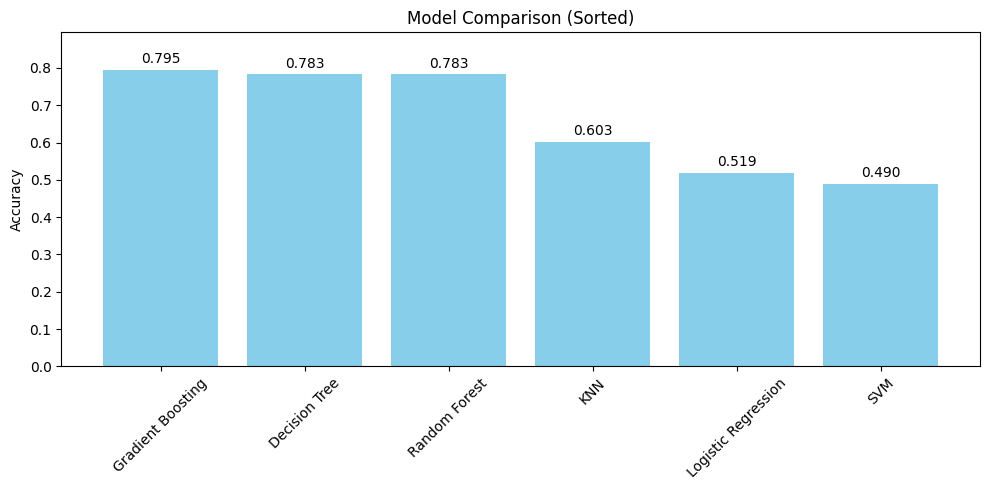

In [27]:
import matplotlib.pyplot as plt

# Sort models by accuracy (descending)
sorted_accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(sorted_accuracies.keys(), sorted_accuracies.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Comparison (Sorted)')
plt.xticks(rotation=45)

# Add padding to the top of the y-axis
max_acc = max(sorted_accuracies.values())
plt.ylim(0, max_acc + 0.1)

# Add accuracy values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

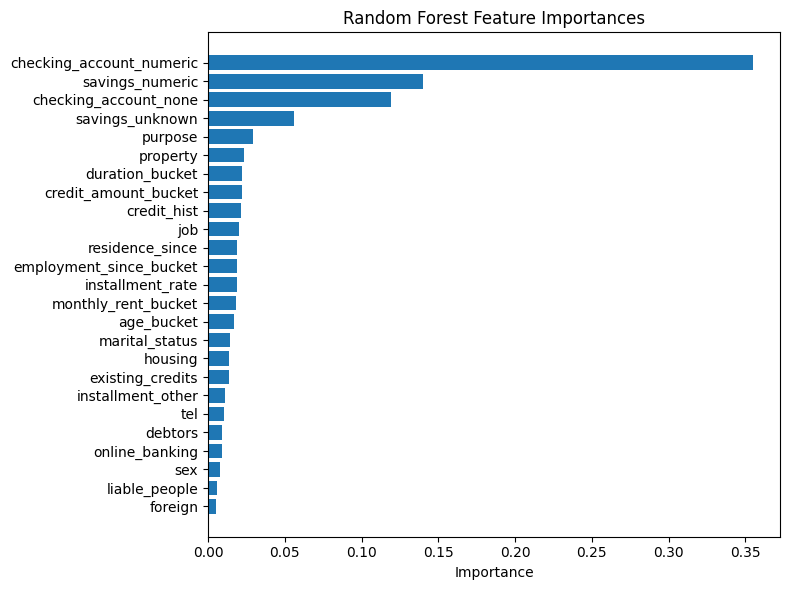

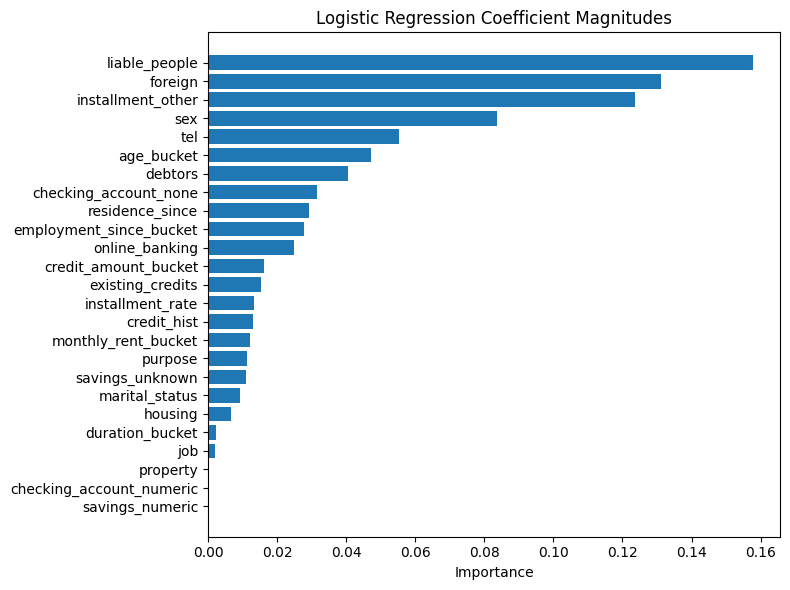

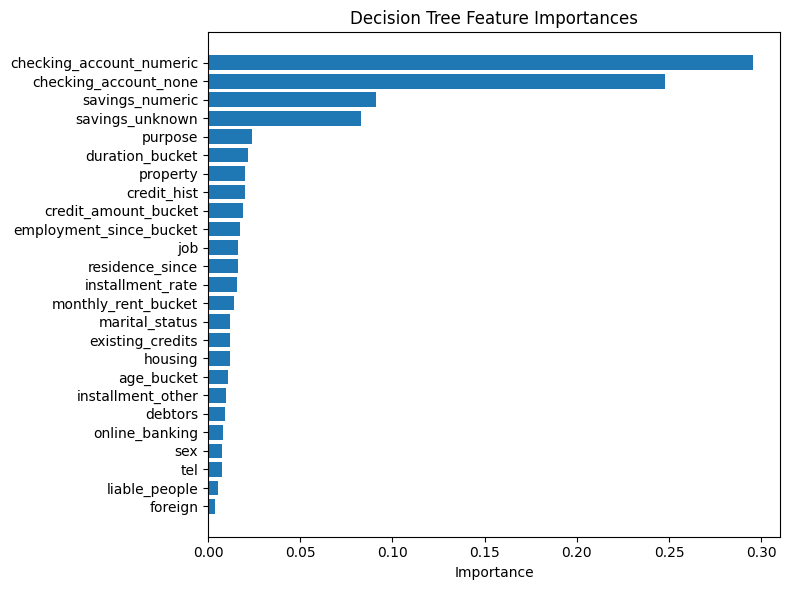

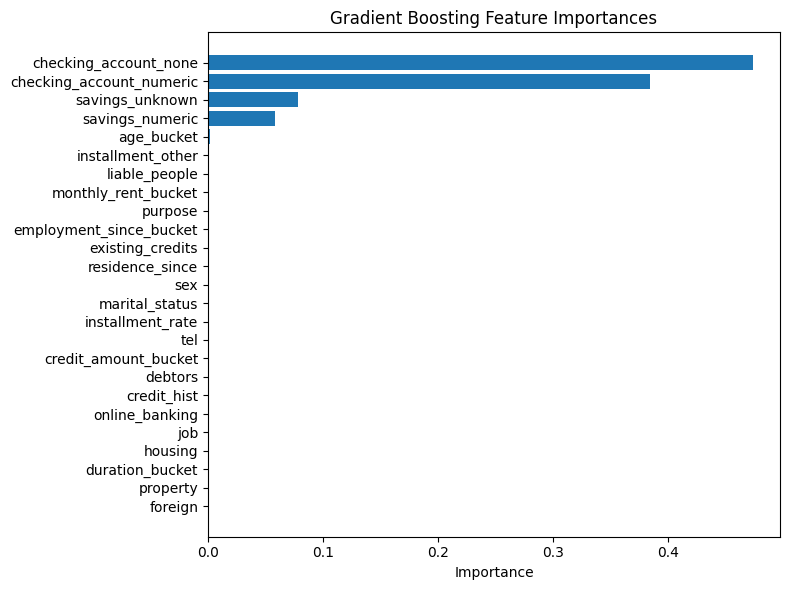

KNN does not support feature importances.
SVM does not support feature importances.


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feature names
feature_names = X.columns.tolist()

def plot_importance(values, title, feature_names):
    sorted_idx = np.argsort(values)[::-1]
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(values)), values[sorted_idx], align='center')
    plt.yticks(range(len(values)), [feature_names[i] for i in sorted_idx])
    plt.xlabel("Importance")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        # Tree-based models
        importances = model.feature_importances_
        plot_importance(importances, f"{name} Feature Importances", feature_names)
    
    elif hasattr(model, "coef_"):
        # Linear models or SVM
        importances = np.abs(model.coef_[0])
        plot_importance(importances, f"{name} Coefficient Magnitudes", feature_names)
    
    else:
        print(f"{name} does not support feature importances.")